fonte: https://www.tensorflow.org/tutorials/images/classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [2]:
batch_size = 5
img_height = 400
img_width = 400

In [3]:
data_dir = '/home/miguel/Apps_Heroku_Flask/kind_of_pet/01_project_model/train/'

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 630 files belonging to 7 classes.
Using 504 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 630 files belonging to 7 classes.
Using 126 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['birds', 'cats', 'dogs', 'fishs', 'hamsters', 'monkeys', 'reptiles']


In [7]:
"""
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
""";

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(5, 400, 400, 3)
(5,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [11]:

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
num_classes = 7

"""

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(units = 64, activation = 'relu'),
  layers.Dense(num_classes, activation='softmax')
])
"""



# Removing overfitting
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
# dropout to reduce the overfitting
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
    
  layers.Dense(units = 16, activation = 'relu'),
  layers.Dense( num_classes, activation= 'softmax' )
])



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.compile(optimizer='Adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 400, 400, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 400, 400, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 400, 400, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 200, 200, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)     

In [15]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

101/101 [==============================] - 68s 661ms/step - loss: 1.9467 - accuracy: 0.1539 - val_loss: 1.9419 - val_accuracy: 0.1349


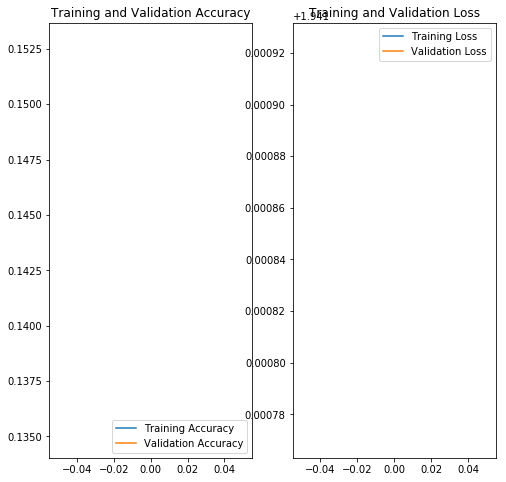

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# Save
model.save('./pet_model_simplified.h5')

### Teste

In [18]:

def pred( path ):
    
    sample_image = tf.keras.preprocessing.image.load_img(f'./some_img_for_test/{path}',target_size=(180,180))
    plt.imshow(sample_image)
    
    # Img to Array
    sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
    # Colocar no formado (1,180,180,3)
    sample_image = np.expand_dims(sample_image,axis=0)

    predictions = model.predict(sample_image)
    
    saida = {
        'birds':   round(predictions[0][0],3),
        'cats':    round(predictions[0][1],3),
        'dogs':    round(predictions[0][2],3),
        'fishs':   round(predictions[0][3],3),
        'hamsters':round(predictions[0][4],3),
        'monkeys': round(predictions[0][5],3),
        'reptiles':round(predictions[0][6],3),
    }
    
    return saida


ValueError: in user code:

    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:425 call
        inputs, training=training, mask=mask)
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/miguel/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 40000 but received input with shape (None, 7744)


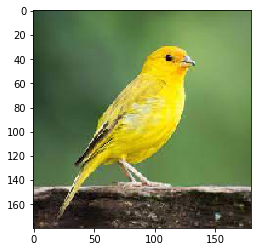

In [19]:
pred('canario.jpg')

In [ ]:
pred('tartaruga.jpg')

In [ ]:
pred('cobra.jpg')

In [ ]:
pred('macaco1.jpeg')

In [ ]:
pred('macaco2.jpeg')

In [ ]:
pred('macaco.jpeg')

In [ ]:
pred('canario1.jpg')

In [ ]:
pred('birds.2.jpg')

In [ ]:
pred('dog99.jpeg')

In [ ]:
pred('reptiles.0.jpg')

In [ ]:
pred('cat.1.jpg')

In [ ]:
pred('dog.jpg')

In [ ]:
pred('gato.jpg')

In [ ]:
pred('lobo.jpg') # ele reconheceu 79% cachorro

In [ ]:
pred('leao.jpg') # Entendeu 99% cachorro

In [ ]:
pred('filhote_leao.jpg') # Entendeu 63% gato

In [ ]:
pred('catdog.png')

In [ ]:
pred('moreia.jpeg')

In [ ]:
pred('fish.jpeg')

In [ ]:
pred('homem2.jpeg')